In [5]:
%matplotlib inline


.. currentmodule:: dgl

DGL at a Glance
=========================

**Author**: `Minjie Wang <https://jermainewang.github.io/>`_, Quan Gan, `Jake
Zhao <https://cs.nyu.edu/~jakezhao/>`_, Zheng Zhang

DGL is a Python package dedicated to deep learning on graphs, built atop
existing tensor DL frameworks (e.g. Pytorch, MXNet) and simplifying the
implementation of graph-based neural networks.

The goal of this tutorial:

- Understand how DGL enables computation on graph from a high level.
- Train a simple graph neural network in DGL to classify nodes in a graph.

At the end of this tutorial, we hope you get a brief feeling of how DGL works.

*This tutorial assumes basic familiarity with pytorch.*


Tutorial problem description
----------------------------

The tutorial is based on the "Zachary's karate club" problem. The karate club
is a social network that includes 34 members and documents pairwise links
between members who interact outside the club.  The club later divides into
two communities led by the instructor (node 0) and the club president (node
33). The network is visualized as follows with the color indicating the
community:

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/img/karate-club.png)

   :align: center

The task is to predict which side (0 or 33) each member tends to join given
the social network itself.



Step 1: Creating a graph in DGL
-------------------------------
Create the graph for Zachary's karate club as follows:



In [2]:
import dgl

def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

Print out the number of nodes and edges in our newly constructed graph:



In [3]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


Visualize the graph by converting it to a `networkx
<https://networkx.github.io/documentation/stable/>`_ graph:



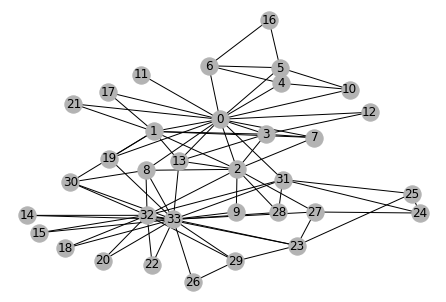

In [4]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

Step 2: Assign features to nodes or edges
--------------------------------------------
Graph neural networks associate features with nodes and edges for training.
For our classification example, we assign each node an input feature as a one-hot vector:
node $v_i$'s feature vector is $[0,\ldots,1,\dots,0]$,
where the $i^{th}$ position is one.

In DGL, you can add features for all nodes at once, using a feature tensor that
batches node features along the first dimension. The code below adds the one-hot
feature for all nodes:



In [9]:
import torch

G.ndata['feat'] = torch.eye(34)

Print out the node features to verify:



In [13]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

# print out node 10 and 11's input features
print(G.nodes[[10, 11]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


Step 3: Define a Graph Convolutional Network (GCN)
--------------------------------------------------
To perform node classification, use the Graph Convolutional Network
(GCN) developed by `Kipf and Welling <https://arxiv.org/abs/1609.02907>`_. Here
is the simplest definition of a GCN framework. We recommend that you 
read the original paper for more details.

- At layer $l$, each node $v_i^l$ carries a feature vector $h_i^l$.
- Each layer of the GCN tries to aggregate the features from $u_i^{l}$ where
  $u_i$'s are neighborhood nodes to $v$ into the next layer representation at
  $v_i^{l+1}$. This is followed by an affine transformation with some
  non-linearity.

The above definition of GCN fits into a **message-passing** paradigm: Each
node will update its own feature with information sent from neighboring
nodes. A graphical demonstration is displayed below.

![mailbox](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/1_first/mailbox.png)

Now, we show that the GCN layer can be easily implemented in DGL.



In [14]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message and reduce function
# NOTE: We ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges 
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In general, the nodes send information computed via the *message functions*,
and aggregate incoming information with the *reduce functions*.

Define a deeper GCN model that contains two GCN layers:



In [15]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

Step 4: Data preparation and initialization
-------------------------------------------

We use one-hot vectors to initialize the node features. Since this is a
semi-supervised setting, only the instructor (node 0) and the club president
(node 33) are assigned labels. The implementation is available as follow.



In [18]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

Step 5: Train then visualize
----------------------------
The training loop is exactly the same as other PyTorch models.
We (1) create an optimizer, (2) feed the inputs to the model,
(3) calculate the loss and (4) use autograd to optimize the model.



In [22]:
net(G, inputs)

tensor([[ 8.4300, -2.4999],
        [ 4.6952, -0.2415],
        [ 3.6634,  2.8481],
        [ 4.8455, -2.2548],
        [ 3.3584, -2.3496],
        [ 3.9447, -2.6707],
        [ 3.9710, -2.6114],
        [ 4.2891, -2.4339],
        [ 2.8370,  2.6328],
        [ 0.7974,  1.2421],
        [ 3.3847, -2.2903],
        [ 1.4815, -1.0468],
        [ 2.0374, -1.2156],
        [ 4.5032, -0.8438],
        [-0.4302,  3.7226],
        [-0.4302,  3.7226],
        [ 1.5135, -1.2048],
        [ 2.5888, -1.7160],
        [-0.4302,  3.7226],
        [ 2.8028, -0.1259],
        [-0.4302,  3.7226],
        [ 2.5888, -1.7160],
        [-0.4302,  3.7226],
        [-0.4340,  5.8302],
        [-0.2437,  1.8755],
        [-0.0344,  1.8311],
        [-0.4190,  2.5606],
        [ 1.0747,  2.5359],
        [ 1.0468,  1.5784],
        [-0.2741,  5.0117],
        [ 0.6705,  3.5244],
        [ 1.8493,  4.2251],
        [ 1.1938,  6.7328],
        [ 0.2383, 10.8088]], grad_fn=<ThAddmmBackward>)

In [23]:
F.log_softmax(net(G, inputs), 1)

tensor([[ -0.0000, -10.9298],
        [ -0.0072,  -4.9439],
        [ -0.3664,  -1.1817],
        [ -0.0008,  -7.1011],
        [ -0.0033,  -5.7113],
        [ -0.0013,  -6.6167],
        [ -0.0014,  -6.5837],
        [ -0.0012,  -6.7242],
        [ -0.5962,  -0.8005],
        [ -0.9401,  -0.4953],
        [ -0.0034,  -5.6784],
        [ -0.0768,  -2.6051],
        [ -0.0379,  -3.2909],
        [ -0.0048,  -5.3517],
        [ -4.1684,  -0.0156],
        [ -4.1684,  -0.0156],
        [ -0.0639,  -2.7822],
        [ -0.0134,  -4.3182],
        [ -4.1684,  -0.0156],
        [ -0.0521,  -2.9809],
        [ -4.1684,  -0.0156],
        [ -0.0134,  -4.3182],
        [ -4.1684,  -0.0156],
        [ -6.2661,  -0.0019],
        [ -2.2326,  -0.1134],
        [ -2.0095,  -0.1439],
        [ -3.0291,  -0.0496],
        [ -1.6698,  -0.2086],
        [ -0.9938,  -0.4623],
        [ -5.2908,  -0.0051],
        [ -2.9099,  -0.0560],
        [ -2.4647,  -0.0889],
        [ -5.5430,  -0.0039],
        [-

In [20]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

all_logits = []
for epoch in range(30):
    
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.4551
Epoch 1 | Loss: 0.3451
Epoch 2 | Loss: 0.2550
Epoch 3 | Loss: 0.1855
Epoch 4 | Loss: 0.1317
Epoch 5 | Loss: 0.0912
Epoch 6 | Loss: 0.0608
Epoch 7 | Loss: 0.0389
Epoch 8 | Loss: 0.0238
Epoch 9 | Loss: 0.0144
Epoch 10 | Loss: 0.0087
Epoch 11 | Loss: 0.0053
Epoch 12 | Loss: 0.0034
Epoch 13 | Loss: 0.0022
Epoch 14 | Loss: 0.0015
Epoch 15 | Loss: 0.0011
Epoch 16 | Loss: 0.0008
Epoch 17 | Loss: 0.0006
Epoch 18 | Loss: 0.0005
Epoch 19 | Loss: 0.0004
Epoch 20 | Loss: 0.0003
Epoch 21 | Loss: 0.0002
Epoch 22 | Loss: 0.0002
Epoch 23 | Loss: 0.0001
Epoch 24 | Loss: 0.0001
Epoch 25 | Loss: 0.0001
Epoch 26 | Loss: 0.0001
Epoch 27 | Loss: 0.0000
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000


This is a rather toy example, so it does not even have a validation or test
set. Instead, Since the model produces an output feature of size 2 for each node, we can
visualize by plotting the output feature in a 2D space.
The following code animates the training process from initial guess
(where the nodes are not classified correctly at all) to the end
(where the nodes are linearly separable).



In [21]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.close()

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/1_first/karate0.png)

   :height: 300px
   :width: 400px
   :align: center



The following animation shows how the model correctly predicts the community
after a series of training epochs.



In [ ]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/1_first/karate.gif)

   :height: 300px
   :width: 400px
   :align: center



Next steps
----------

In the :doc:`next tutorial <2_basics>`, we will go through some more basics
of DGL, such as reading and writing node/edge features.

